In [0]:
pip install --upgrade tensorflow

  Using cached https://files.pythonhosted.org/packages/85/d4/c0cd1057b331bc38b65478302114194bd8e1b9c2bbc06e300935c0e93d90/tensorflow-2.1.0-cp36-cp36m-manylinux2010_x86_64.whl


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZAOED8/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
print(tf.__version__)

2.1.0


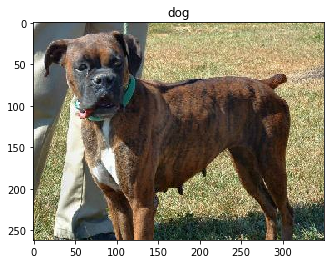

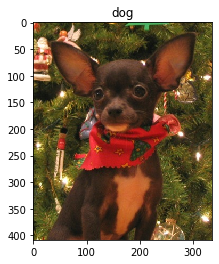

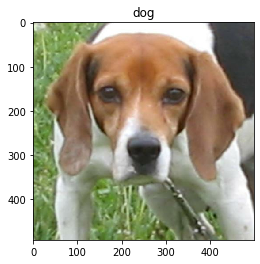

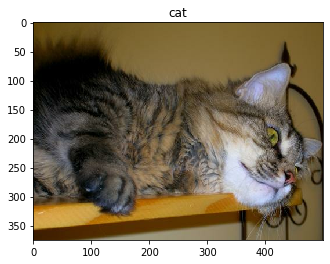

In [0]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(4):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [0]:
IMG_SIZE = 160
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
#applying/processing using format_example() for train,test,validation using map function
train = raw_train.map(format_example)
test = raw_test.map(format_example)
validation = raw_validation.map(format_example)

In [0]:
#shuffling and batching data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
for image_batch, label_batch in train_batches.take(1):
  pass
#print(image_batch.shape)
image_batch.shape

TensorShape([32, 160, 160, 3])

In [0]:
#loading MobileNetV2 model

IMAGE_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMAGE_SHAPE, include_top = False, weights = 'imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
#testing feature extraction
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
#In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
#Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [0]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [0]:
#Now stack the feature extractor, and these two layers using a tf.keras.Sequential model:
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             prediction_layer
])

In [0]:
#Compile the model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss = tf.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#trainable variables
len(model.trainable_variables)

2

In [0]:
#Train the model
initial_epochs = 10
validation_steps = 20
loss_0, accuracy_0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 131ms/step - loss: 0.5781 - accuracy: 0.6078


In [0]:
print("initial_loss : {:.2f}".format(loss_0))
print("initial_accuracy : {:.2f}".format(accuracy_0))

initial_loss : 0.58
initial_accuracy : 0.61


In [0]:
history = model.fit(train_batches,
                    epochs = initial_epochs,
                    validation_data = validation_batches)

Epoch 1/10
582/582 [==============================] - 56s 96ms/step - loss: 0.3534 - accuracy: 0.8323 - val_loss: 0.1711 - val_accuracy: 0.9024
Epoch 2/10
582/582 [==============================] - 54s 93ms/step - loss: 0.1965 - accuracy: 0.9194 - val_loss: 0.1262 - val_accuracy: 0.9304
Epoch 3/10
582/582 [==============================] - 53s 92ms/step - loss: 0.1630 - accuracy: 0.9330 - val_loss: 0.1116 - val_accuracy: 0.9402
Epoch 4/10
582/582 [==============================] - 53s 91ms/step - loss: 0.1483 - accuracy: 0.9389 - val_loss: 0.1056 - val_accuracy: 0.9428
Epoch 5/10
582/582 [==============================] - 54s 92ms/step - loss: 0.1369 - accuracy: 0.9435 - val_loss: 0.1026 - val_accuracy: 0.9450
Epoch 6/10
582/582 [==============================] - 53s 91ms/step - loss: 0.1321 - accuracy: 0.9458 - val_loss: 0.0968 - val_accuracy: 0.9480
Epoch 7/10
582/582 [==============================] - 53s 92ms/step - loss: 0.1273 - accuracy: 0.9468 - val_loss: 0.1016 - val_accuracy:

<function matplotlib.pyplot.show>

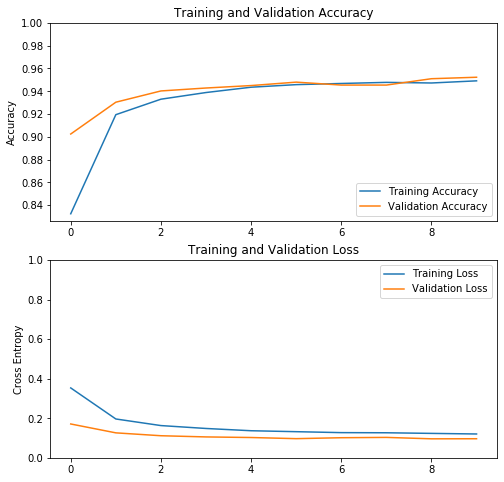

In [0]:
#Learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')

plt.show

In [0]:
#Un-freezing top layers - training some more layers than only training top layer and classifier as above.(fine - tuning)
base_model.trainable = True

In [0]:
print("No. of layers in the base_model:", len(base_model.layers))

No. of layers in the base_model: 155


In [0]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
# leaving 100 layers with previously trained weights and adjusting/training remaining 55 layers

In [0]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                                                        optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate/10),
                                                        metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
len(model.trainable_variables)

58

In [0]:
# training the model with 58 trainable layers
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_batches,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 58s 100ms/step - loss: 0.0993 - accuracy: 0.9598 - val_loss: 0.0564 - val_accuracy: 0.9785
Epoch 11/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0694 - accuracy: 0.9724 - val_loss: 0.0537 - val_accuracy: 0.9781
Epoch 12/20
582/582 [==============================] - 55s 94ms/step - loss: 0.0594 - accuracy: 0.9771 - val_loss: 0.0621 - val_accuracy: 0.9776
Epoch 13/20
582/582 [==============================] - 54s 92ms/step - loss: 0.0449 - accuracy: 0.9830 - val_loss: 0.0563 - val_accuracy: 0.9781
Epoch 14/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0355 - accuracy: 0.9873 - val_loss: 0.0542 - val_accuracy: 0.9794
Epoch 15/20
582/582 [==============================] - 55s 94ms/step - loss: 0.0305 - accuracy: 0.9889 - val_loss: 0.0533 - val_accuracy: 0.9811
Epoch 16/20
582/582 [==============================] - 54s 93ms/step - loss: 0.0242 - accuracy: 0.9915 - val_loss: 0.0554 - val_a

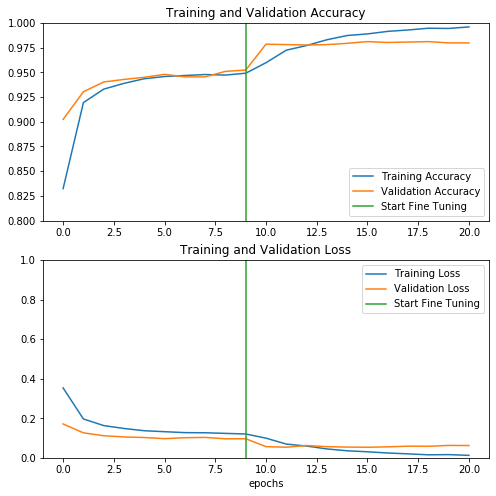

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()